# How to predict Gold and Silver prices based on other trends
### The aim for this project, is to use historical data of minerals and indexes to try and see if it is possible to predict the daily price of gold and silver. Obviously this isn't meant to encourage people into 'trading' gold and silver, because they are long term ways to keep your money safer than in "cash", as Robert Kiyosaki says "Gold and Silver are God's money". So the objective here is to learn how we can use PyTorch to test if we can predict gold and silver prices going up because of all the money that is going to be printed.

In [65]:
import torch
import numpy as np
from torch import nn
import math, time
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import missingno as msno
import seaborn as sns
import gc


In [66]:
# This data was obtained through https://www.investing.com/commodities/metals
silver = pd.read_csv('datasets/Finance/Silver Futures Historical Data.csv')
gold = pd.read_csv('datasets/Finance/Gold Futures Historical Data.csv')
copper = pd.read_csv('datasets/Finance/Copper Futures Historical Data.csv')
palladium = pd.read_csv('datasets/Finance/Palladium Futures Historical Data.csv')
platinum = pd.read_csv('datasets/Finance/Platinum Futures Historical Data.csv')

In [67]:
silver.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,02/28/2023,20.878,20.723,20.942,20.508,NaN,0.75%
1,02/27/2023,20.723,20.872,20.930,20.642,NaN,-0.73%
2,02/26/2023,20.875,20.855,20.942,20.850,NaN,0.31%
3,02/24/2023,20.810,21.330,21.395,20.725,51.63K,-2.33%
4,02/23/2023,21.306,21.520,21.670,21.260,52.99K,-1.71%


In [68]:
gold.tail()

,Date,Price,Open,High,Low,Vol.,Change %
2604,02/04/2013,"1,676.40","1,669.10","1,678.60","1,661.80",112.53K,0.35%
2605,02/01/2013,"1,670.60","1,665.20","1,683.00","1,660.60",177.05K,0.52%
2606,01/31/2013,"1,662.00","1,677.00","1,681.70","1,658.40",159.62K,-1.17%
2607,01/30/2013,"1,681.60","1,664.10","1,685.00","1,663.50",183.22K,1.25%
2608,01/29/2013,"1,660.80","1,653.90","1,665.00","1,653.50",145.86K,0.48%


In [69]:
copper.tail()

,Date,Price,Open,High,Low,Vol.,Change %
2597,02/03/2013,3.7760,3.7310,3.7760,3.7310,0.11K,-0.41%
2598,02/01/2013,3.7915,3.7350,3.7895,3.7345,0.18K,1.39%
2599,01/31/2013,3.7395,3.7555,3.7755,3.7345,0.19K,-0.49%
2600,01/30/2013,3.7580,3.7095,3.7620,3.7080,0.44K,1.80%
2601,01/29/2013,3.6915,3.6585,3.6940,3.6525,49.61K,0.82%


In [70]:
palladium.tail()

,Date,Price,Open,High,Low,Vol.,Change %
2863,02/04/2013,756.70,757.90,762.10,748.20,NaN,0.05%
2864,02/01/2013,756.30,743.70,758.50,739.80,NaN,1.68%
2865,01/31/2013,743.80,749.40,751.70,735.90,NaN,-0.73%
2866,01/30/2013,749.30,751.20,760.30,745.40,NaN,-0.24%
2867,01/29/2013,751.10,738.40,751.30,737.40,NaN,1.84%


In [71]:
platinum.tail()

,Date,Price,Open,High,Low,Vol.,Change %
3132,02/01/2013,"1,684.70","1,677.15","1,693.65","1,668.45",NaN,0.45%
3133,01/31/2013,"1,677.10","1,688.80","1,688.80","1,667.45",NaN,-0.70%
3134,01/30/2013,"1,688.85","1,682.35","1,693.45","1,679.15",NaN,0.39%
3135,01/29/2013,"1,682.30","1,668.70","1,682.60","1,665.80",NaN,0.82%
3136,01/28/2013,"1,668.65","1,693.75","1,699.25","1,659.95",NaN,-1.46%


In [72]:
len(silver), len(gold), len(copper), len(palladium), len(platinum)

(2605, 2609, 2602, 2868, 3137)

### Data completion
Even though data was captured in almost the same interval, there seems to be more data in some cases, or maybe there is missing data in some time intervals. So next task will be to check whats the missing data.

In [73]:
# Check for null values and where they are
silver.isnull().sum(), silver.isnull().mean()*100

(Date         0
 Price        0
 Open         0
 High         0
 Low          0
 Vol.        29
 Change %     0
 dtype: int64,
 Date        0.000000
 Price       0.000000
 Open        0.000000
 High        0.000000
 Low         0.000000
 Vol.        1.113244
 Change %    0.000000
 dtype: float64)

In [74]:
gold.isnull().sum(), gold.isnull().mean()*100

(Date         0
 Price        0
 Open         0
 High         0
 Low          0
 Vol.        10
 Change %     0
 dtype: int64,
 Date        0.000000
 Price       0.000000
 Open        0.000000
 High        0.000000
 Low         0.000000
 Vol.        0.383289
 Change %    0.000000
 dtype: float64)

In [75]:
copper.isnull().sum(), copper.isnull().mean()*100

(Date         0
 Price        0
 Open         0
 High         0
 Low          0
 Vol.        64
 Change %     0
 dtype: int64,
 Date        0.000000
 Price       0.000000
 Open        0.000000
 High        0.000000
 Low         0.000000
 Vol.        2.459646
 Change %    0.000000
 dtype: float64)

In [76]:
palladium.isnull().sum(), palladium.isnull().mean()*100

(Date           0
 Price          0
 Open           0
 High           0
 Low            0
 Vol.        1717
 Change %       0
 dtype: int64,
 Date         0.000000
 Price        0.000000
 Open         0.000000
 High         0.000000
 Low          0.000000
 Vol.        59.867503
 Change %     0.000000
 dtype: float64)

In [77]:
platinum.isnull().sum(), platinum.isnull().mean()*100

(Date           0
 Price          0
 Open           0
 High           0
 Low            0
 Vol.        2582
 Change %       0
 dtype: int64,
 Date         0.000000
 Price        0.000000
 Open         0.000000
 High         0.000000
 Low          0.000000
 Vol.        82.307938
 Change %     0.000000
 dtype: float64)

<AxesSubplot: >

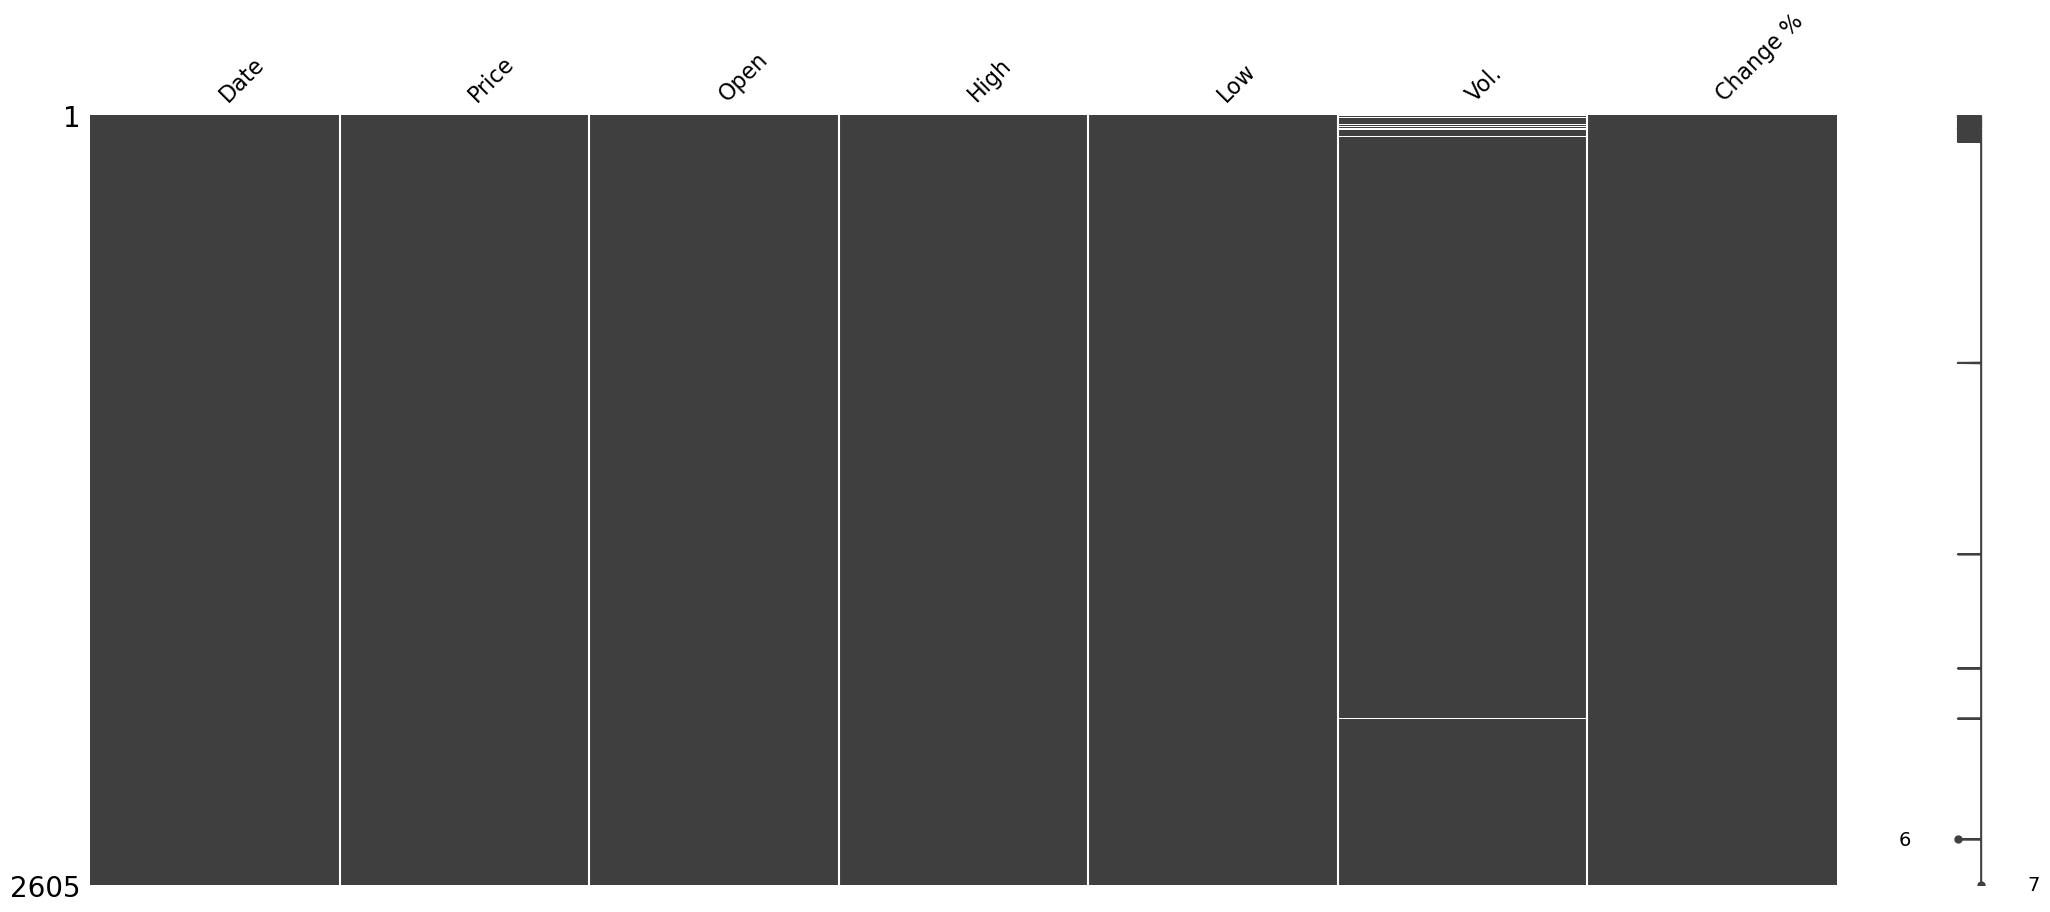

In [78]:
msno.matrix(silver)

<AxesSubplot: >

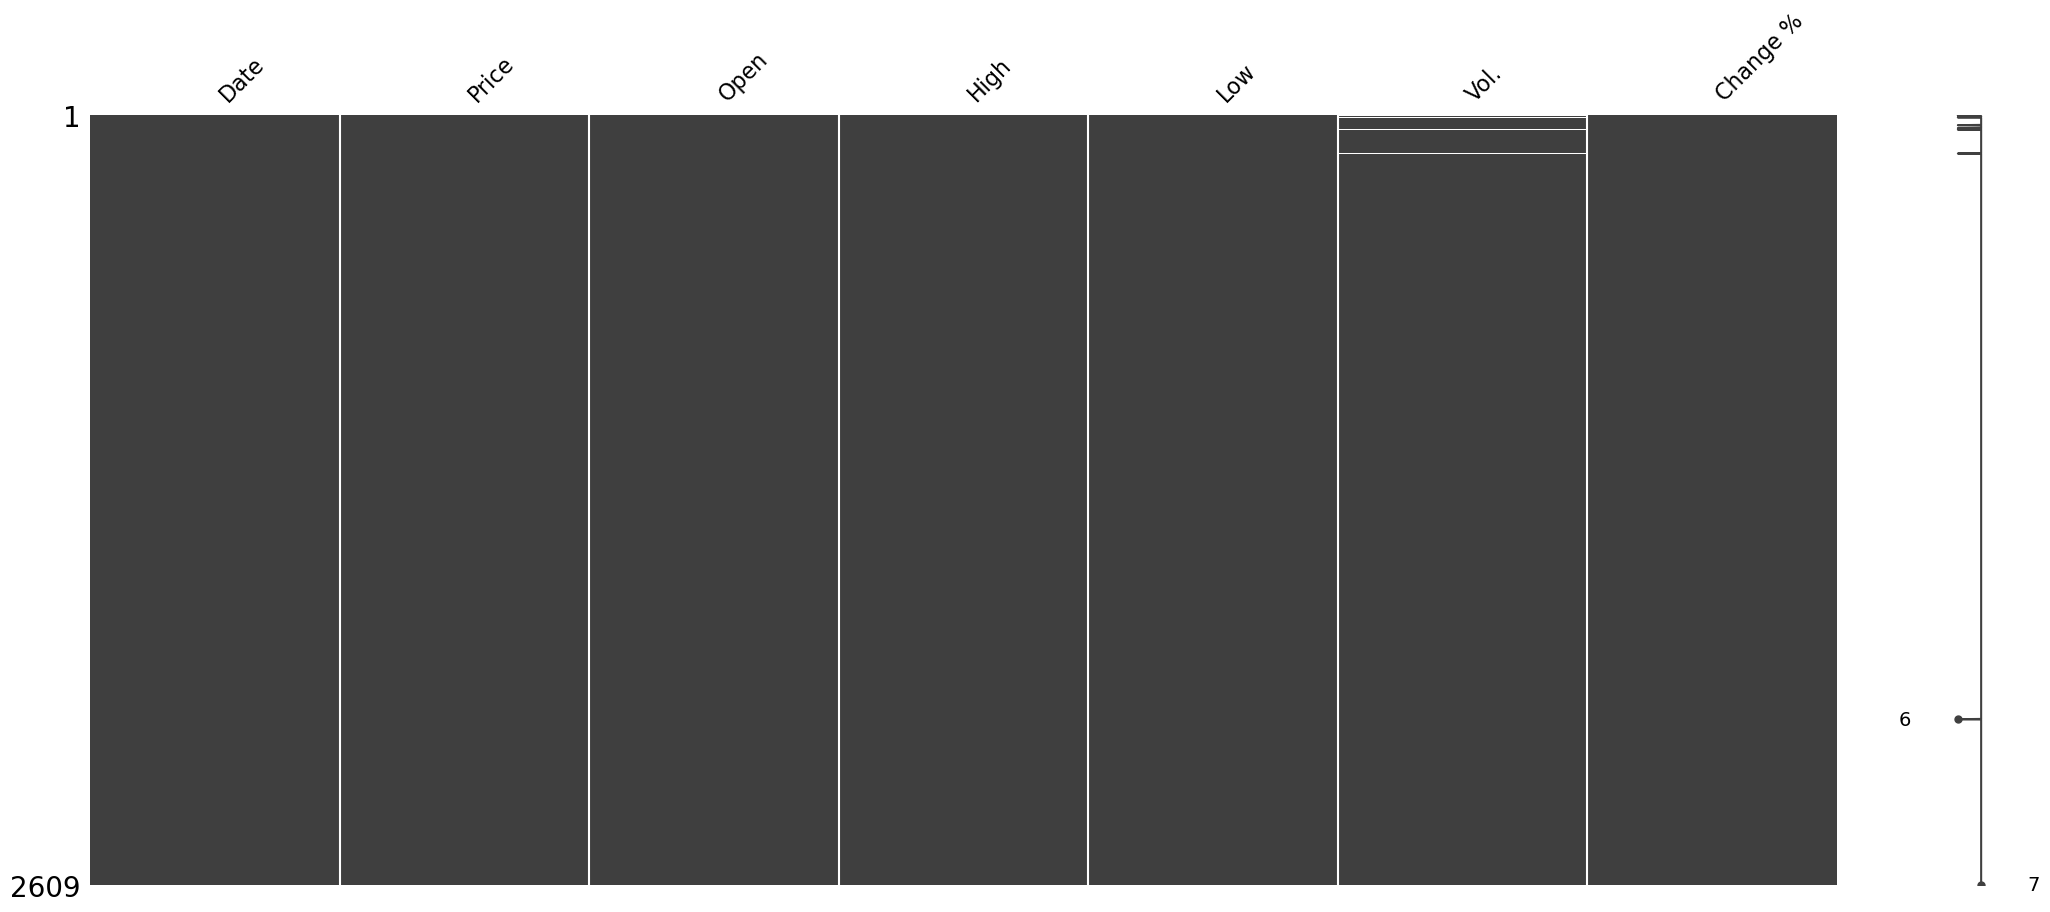

In [79]:
 msno.matrix(gold)

<AxesSubplot: >

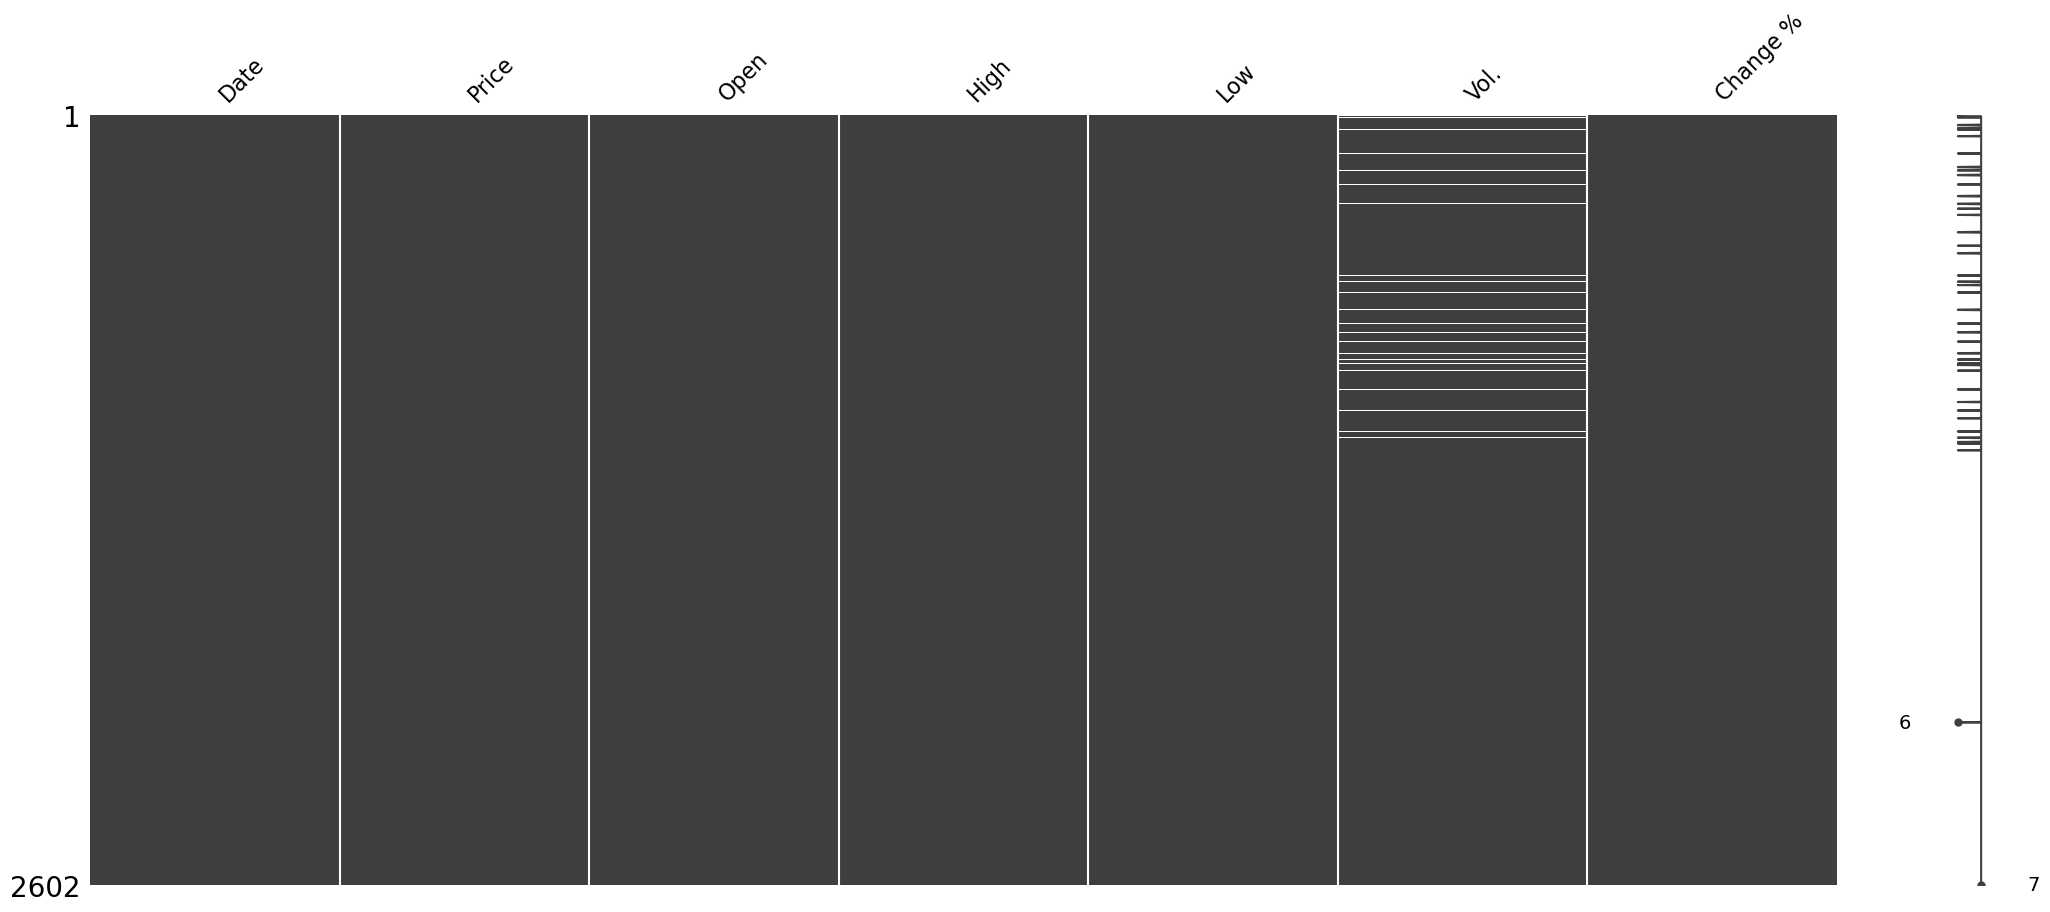

In [80]:
msno.matrix(copper)

<AxesSubplot: >

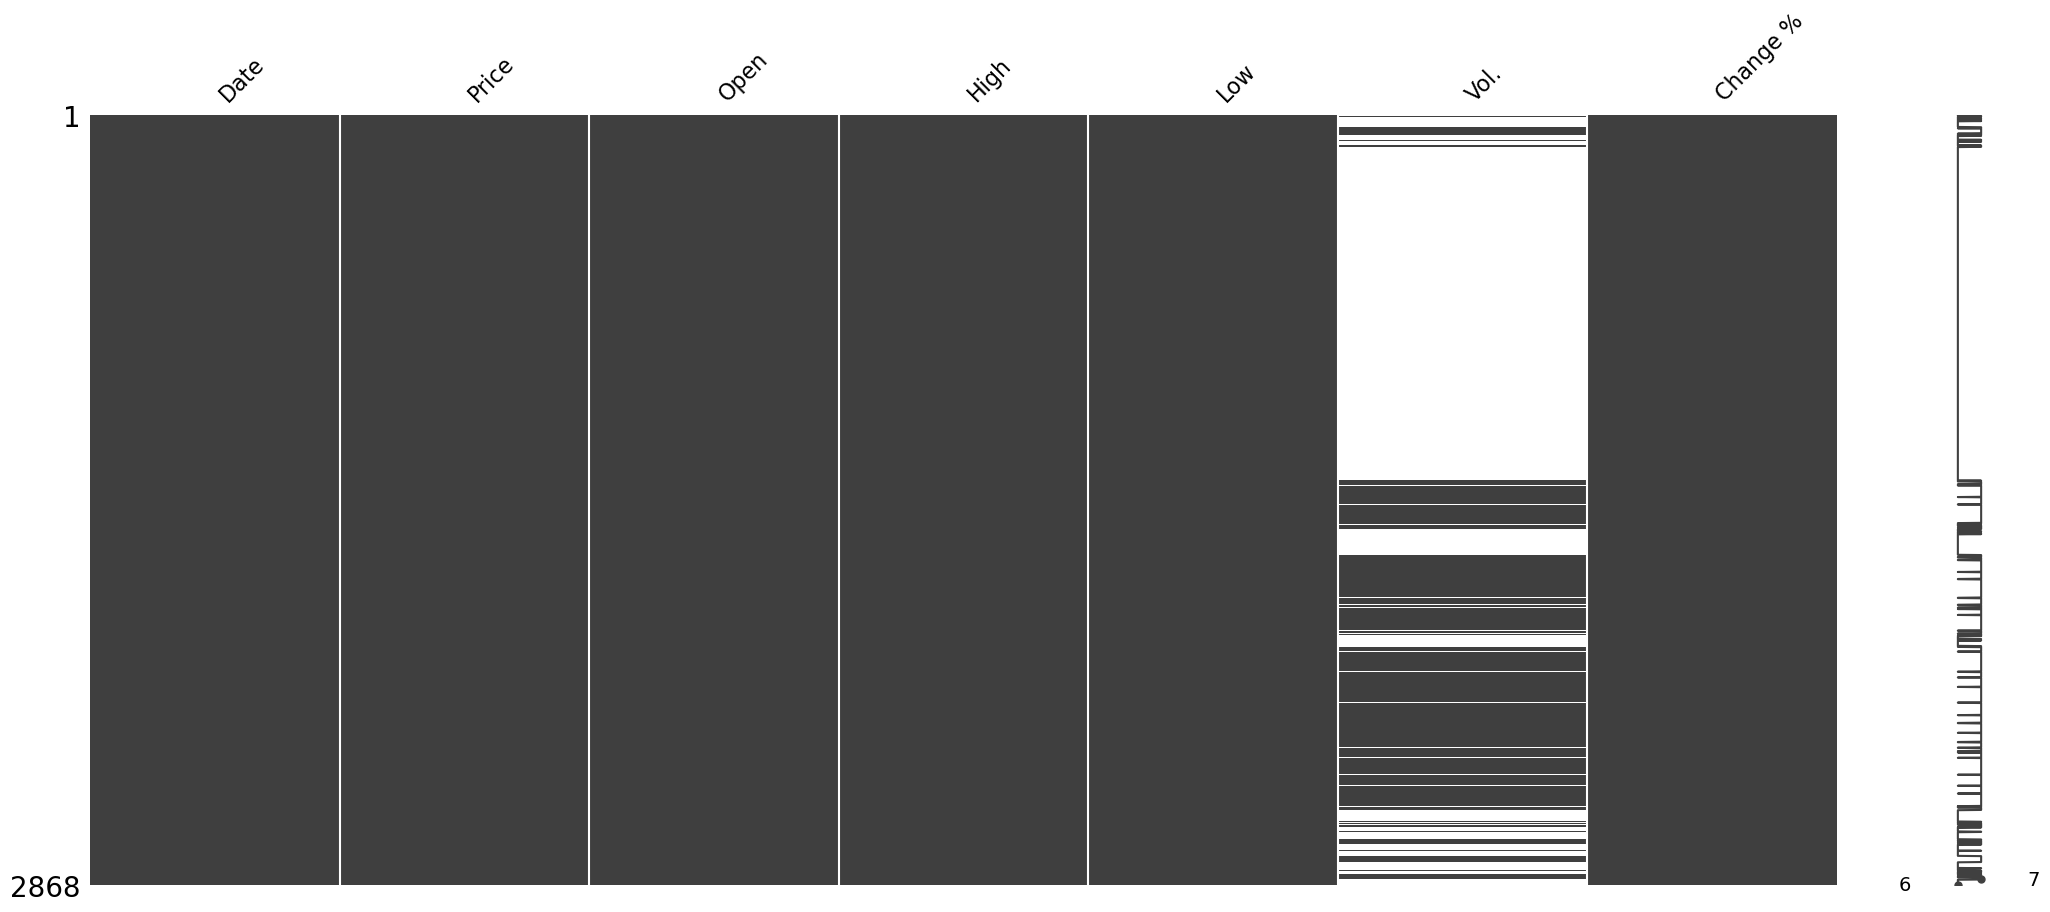

In [81]:
msno.matrix(palladium)

<AxesSubplot: >

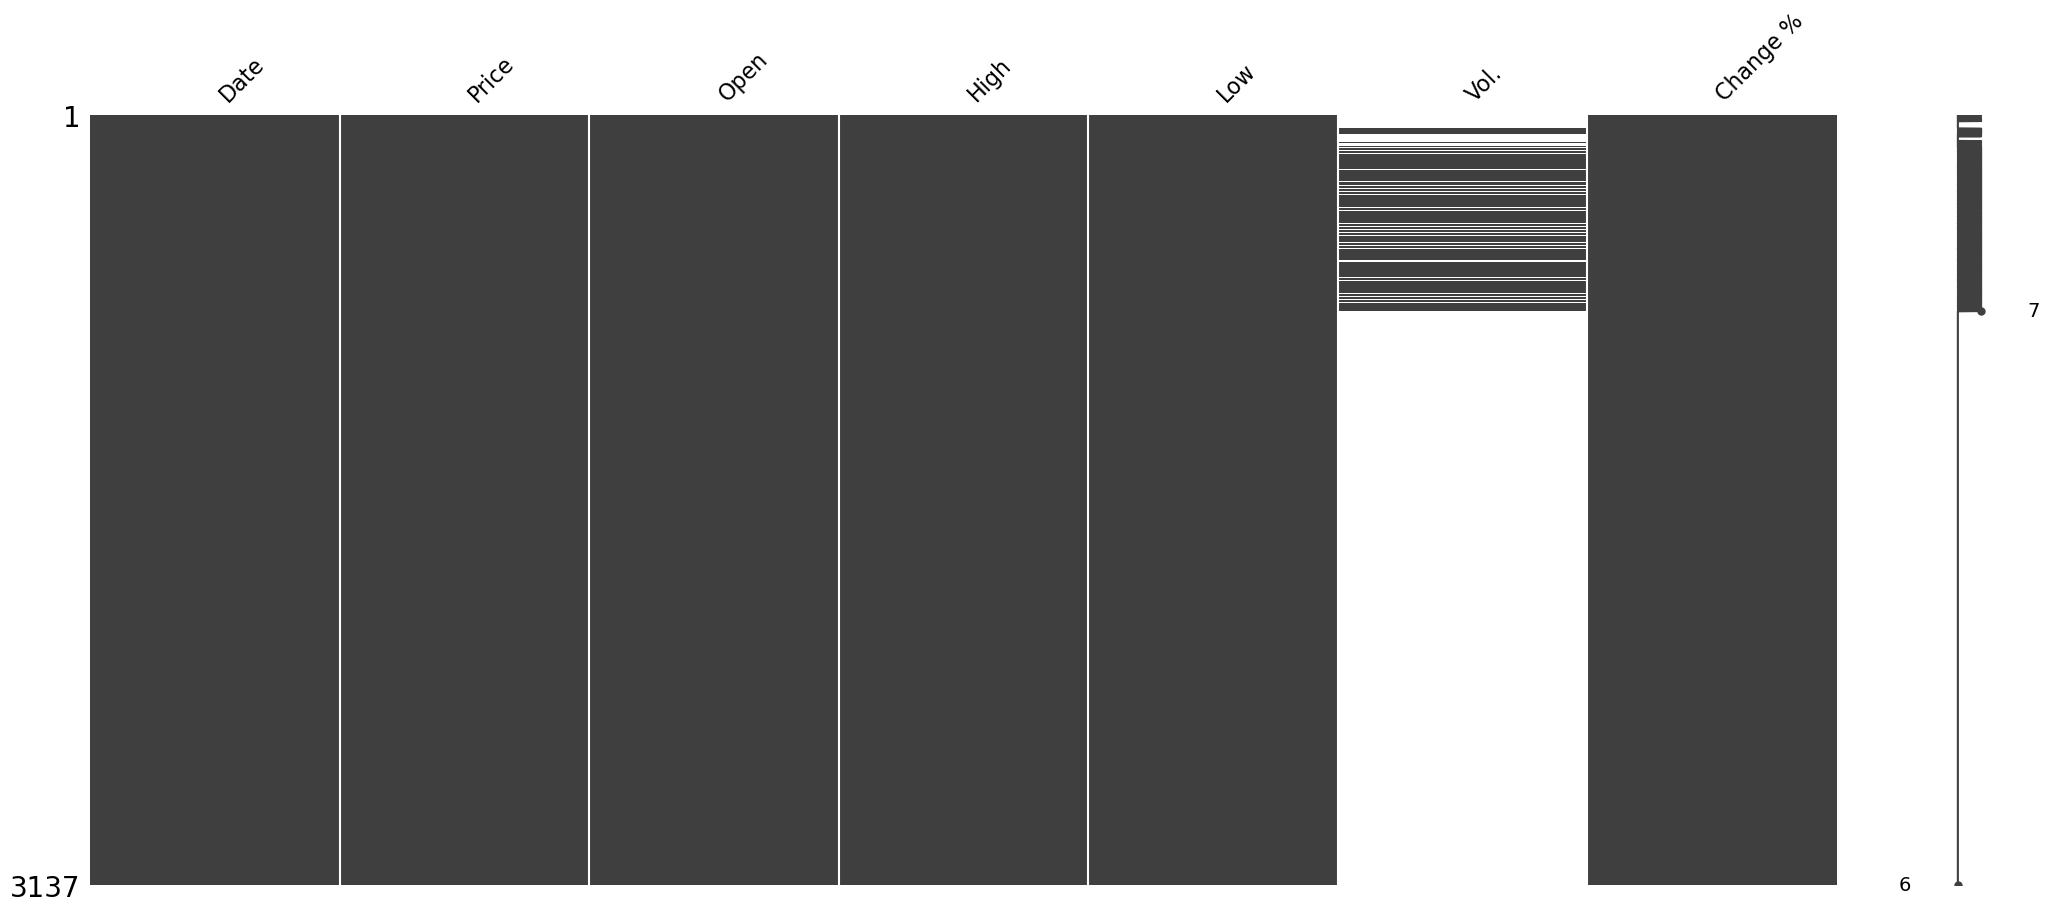

In [82]:
msno.matrix(platinum)

### Checking data types

In [83]:
silver["Date"].dtype, silver["Price"].dtype, silver["Open"].dtype, silver["High"].dtype, silver["Low"].dtype, silver["Vol."].dtype, silver["Change %"].dtype

(dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'))

In [84]:
gold["Date"].dtype, gold["Price"].dtype, gold["Open"].dtype, gold["High"].dtype, gold["Low"].dtype, gold["Vol."].dtype, gold["Change %"].dtype

(dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'))

In [85]:
copper["Date"].dtype, copper["Price"].dtype, copper["Open"].dtype, copper["High"].dtype, copper["Low"].dtype, copper["Vol."].dtype, copper["Change %"].dtype

(dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'))

In [ ]:
palladium["Date"].dtype, palladium["Price"].dtype, palladium["Open"].dtype, palladium["High"].dtype, palladium["Low"].dtype, palladium["Vol."].dtype, palladium["Change %"].dtype

In [ ]:
platinum["Date"].dtype, platinum["Price"].dtype, platinum["Open"].dtype, platinum["High"].dtype, platinum["Low"].dtype, platinum["Vol."].dtype, platinum["Change %"].dtype

### Addressing the data type problems
 * K
 * , for thousand units
 * %
 
 Data with K will be left as it is, because all is in the same format with K, excepto from the NaN values.

In [ ]:
# Format values
silver["Vol."] = silver["Vol."].str.replace('K', '').astype('float')
silver["Change %"] = silver["Change %"].str.replace('%', '').astype('float')

copper["Vol."] = gold["Vol."].str.replace('K', '').astype('float')
copper["Change %"] = copper["Change %"].str.replace('%', '').astype('float')

gold["Vol."] = gold["Vol."].str.replace('K', '').astype('float')
gold["Change %"] = gold["Change %"].str.replace('%', '').astype('float')
gold["Price"] = gold["Price"].str.replace(',', '').astype('float')
gold["Open"] = gold["Open"].str.replace(',', '').astype('float')
gold["High"] = gold["High"].str.replace(',', '').astype('float')
gold["Low"] = gold["Low"].str.replace(',', '').astype('float')

In [ ]:
# Format date
silver['Date'] = pd.to_datetime(silver['Date'], format='%m/%d/%Y')
gold['Date'] = pd.to_datetime(gold['Date'], format='%m/%d/%Y')
copper['Date'] = pd.to_datetime(copper['Date'], format='%m/%d/%Y')
palladium['Date'] = pd.to_datetime(palladium['Date'], format='%m/%d/%Y')
platinum['Date'] = pd.to_datetime(platinum['Date'], format='%m/%d/%Y')

In [ ]:
# To check where are the missing values, 
# I must first create a new dataframe with the complete days for the given time interval
date_range = pd.date_range(
    min(silver['Date'].min(), palladium['Date'].min()), 
    max(silver['Date'].max(), palladium['Date'].max()), freq='D')
date_df = pd.DataFrame({'Date': date_range})

merged_df_silver = pd.merge(date_df, silver, how='left', on='Date')
merged_df_gold = pd.merge(date_df, gold, how='left', on='Date')
merged_df_copper = pd.merge(date_df, copper, how='left', on='Date')
merged_df_palladium = pd.merge(date_df, palladium, how='left', on='Date')
merged_df_platinum = pd.merge(date_df, platinum, how='left', on='Date')

missing_dates_silver = merged_df_silver[merged_df_silver['Price'].isnull()]
missing_dates_gold = merged_df_gold[merged_df_gold['Price'].isnull()]
missing_dates_copper = merged_df_copper[merged_df_copper['Price'].isnull()]
missing_dates_palladium = merged_df_palladium[merged_df_palladium['Price'].isnull()]
missing_dates_platinum = merged_df_platinum[merged_df_platinum['Price'].isnull()]

print("Missing values of silver")
print(len(missing_dates_silver))
print("Missing values of gold")
print(len(missing_dates_gold))
print("Missing values of copper")
print(len(missing_dates_copper))
print("Missing values of palladium")
print(len(missing_dates_palladium))
print("Missing values of platinum")
print(len(missing_dates_platinum))

In [ ]:
# Now we can see that the missing data is way more that we expected
# The model I want to make is designed to work by a daily base, so it's easier to keep track and fix
# So we need to fill the gaps
# But this can be fixed by using data imputation techniques
merged_df_silver["Price"][:100].plot(title="Silver Price with missing days", figsize=(20,10))

* But what are these missing values? They seem to be continuous, and probably is because markets close on Saturday.
* And also, even though data was obtained in the same time range, there are different quantities of missing data, so probably there is even more reasons to that, so we can't be 100% sure.
* So the best would be trying to complete the missing parts based on the previous and future values.

# Data imputation

Source: https://github.com/Idilismiguzel/data_analysis/blob/main/missing_data/Missing_Value_Imputation.ipynb

### Fillna is a method which can fill the missing data points
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html

There are different type of fill types
* bfill: use next valid observation to fill gap
* ffill: propagate last valid observation forward to next valid backfill

In [ ]:
merged_df_silver_imp = merged_df_silver["Price"].fillna(method="ffill")
merged_df_silver_imp_2 = merged_df_silver["Price"].fillna(method="bfill")

merged_df_silver_imp[:100].plot(color="red", linestyle="dotted", figsize=(20,10))
merged_df_silver_imp_2[:100].plot(color="green", linestyle="dotted", figsize=(20,10))
merged_df_silver["Price"][:100].plot(title="Silver Price with missing days", figsize=(20,10))

In [ ]:
# The problem with this is that in this scenario, one is too optimistic and the other is too pessimistic
# So I would prefer a middle ground
merged_df_silver_linear = merged_df_silver["Price"].interpolate(method="linear")

merged_df_silver_linear[:100].plot(color="purple", linestyle="dotted", figsize=(20,10))
merged_df_silver_imp[:100].plot(color="red", linestyle="dotted", figsize=(20,10))
merged_df_silver_imp_2[:100].plot(color="green", linestyle="dotted", figsize=(20,10))
merged_df_silver["Price"][:100].plot(title="Silver Price with missing days", figsize=(20,10))

In [ ]:
# New dataset (tomato) vs Old (blue)
merged_df_silver_linear.plot(title="Completed Silver Price", figsize=(20,10), color="tomato")
merged_df_silver["Price"].plot(figsize=(20,10), color="blue")

In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(merged_df_silver_linear.values.reshape(-1,1))
scaled_data

# Shaping Data

* **Time series problem**: how to predict something based on time order. We cannot just simply make a range of 0 to n, indexing every data point, because, when we train the model, we'll use the time to train the model and to predict we will use the price data. If the data is just a simple 0 to n, it will just mean that our training data is a straight line. So we have to make a function that actually relates both the date and the data. In short we want a model that we input a future date, and we output the predicted price for that specific date, or prices for a set of dates.


In [ ]:
# https://www.crosstab.io/articles/time-series-pytorch-lstm/
class SilverDataset(Dataset):
    def __init__(self, features, target, seq_length=7):
        self.X = torch.tensor(features).float()
        self.y = torch.tensor(target).float()
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X.shape[0])

    def __getitem__(self, idx):
        if idx >= self.seq_length - 1:
            idx_start = idx - self.seq_length + 1
            x = self.X[idx_start:(idx + 1), :]
        else:
            padding = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)
            
        return x, self.y[idx]

In [ ]:
#https://github.com/RodolfoLSS/stock-prediction-pytorch/blob/master/stock-prediction-pytorch.ipynb
#https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/

# This method takes the n-1 values from data to make X with n = lookback, and the value number n to make the target y
# So that basically uses [0, n-1] values with the target value at pos [n]
def split_data(data_raw, lookback):
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback + 1): # I Modified this part to generate the last piece of data missing
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.32*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
def batch_data(data_raw, lookback):
    data = []
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback + 1): # I Modified this part to generate the last piece of data missing
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_ = data[:,:-1,:]
    y_ = data[:,-1,:]
    
    return [x_,y_]

In [ ]:
seq_length=128

In [ ]:
x_silver_data, y_silver_data = batch_data(scaled_data, seq_length)
x_silver_train, y_silver_train, x_silver_test, y_silver_test = split_data(scaled_data, seq_length)
print('x_train.shape = ',x_silver_train.shape)
print('y_train.shape = ',y_silver_train.shape)
print('x_test.shape = ',x_silver_test.shape)
print('y_test.shape = ',y_silver_test.shape)
print('X_full.shape = ', x_silver_data.shape)
print('y_full.shape = ', y_silver_data.shape)

In [ ]:
x_silver_data[-10:]

In [ ]:
y_silver_data[-10:]

- The test data has the last 20% of the data, and the y array has the target values.
- Here we can see the comparison with the original data and the last values of y
- The difference is we filled with values for the 25 of feb

In [ ]:
silver.head(), print(scaler.inverse_transform(y_silver_test[:-1][-4:]))

# GRU (gated recurrent unit) & LSTM (long short term memory)
- GRUs or LSTMs (long short term memory) have been used to solve time series problems.
- GRU: 

https://pytorch.org/docs/stable/generated/torch.nn.GRU.html?highlight=gru#torch.nn.GRU

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM

https://arxiv.org/pdf/1412.3555.pdf
- LSTM: 

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [ ]:
x_silver_train = torch.from_numpy(x_silver_train).type(torch.Tensor)
x_silver_test = torch.from_numpy(x_silver_test).type(torch.Tensor)

y_silver_train_lstm = torch.from_numpy(y_silver_train).type(torch.Tensor)
y_silver_test_lstm = torch.from_numpy(y_silver_test).type(torch.Tensor)

y_silver_train_gru = torch.from_numpy(y_silver_train).type(torch.Tensor)
y_silver_test_gru = torch.from_numpy(y_silver_test).type(torch.Tensor)

### FULL
x_silver_data = torch.from_numpy(x_silver_data).type(torch.Tensor)
y_silver_data = torch.from_numpy(y_silver_data).type(torch.Tensor)

In [ ]:
#Setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define hyperparameters
input_size = 1
num_layers= 2
hidden_size = 16
output_size = 1
num_epochs = 50 # The model learns fast enough
learning_rate = 0.01

print(device)

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.2):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout_prob)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
silver_model_gru = GRU(input_size, hidden_size, num_layers, output_size)
silver_model_gru

In [ ]:
silver_model_lstm = LSTM(input_size, hidden_size, num_layers, output_size)
silver_model_lstm


In [ ]:
# Setup loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean')
optimizer_gru = torch.optim.Adam(silver_model_gru.parameters(), 
                             lr=learning_rate)
optimizer_lstm = torch.optim.Adam(silver_model_lstm.parameters(), 
                             lr=learning_rate)

In [ ]:
# Training LSTM
hist = np.zeros(num_epochs)
hist_test = np.zeros(num_epochs)

start_time = time.time()

for epoch in range(num_epochs):
    #Train
    silver_model_lstm.train()
    
    # Forward pass
    y_train_pred_lstm = silver_model_lstm(x_silver_train)

    # Calculate the loss
    loss = loss_fn(y_train_pred_lstm, y_silver_train_lstm)
    hist[epoch] = loss.item()

    # Optimizer zero grad
    optimizer_lstm.zero_grad()
    
    # Loss backward
    loss.backward()
    
    # Step the optimizer
    optimizer_lstm.step()
    
    # Test
    silver_model_lstm.eval()

    with torch.inference_mode():
        y_test_pred_lstm = silver_model_lstm(x_silver_test)
        test_loss = loss_fn(y_test_pred_lstm, y_silver_test_lstm)
        hist_test[epoch] = test_loss.item()

    if epoch % 10 == 0:
        print("Epoch ", epoch, 
              f"MSE: {loss.item():.5f}", 
              f"Test MSE: {test_loss.item():.5}"
             )
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred_lstm.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_silver_train_lstm.detach().numpy()))
predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred_lstm.detach().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_silver_test_lstm.detach().numpy()))

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 3, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 3, 2)
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Test Prediction (LSTM)", color='tomato')
ax.set_title('Silver price Test', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 3, 3)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
hist_gru = np.zeros(num_epochs)
hist_gru_test = np.zeros(num_epochs)

start_time = time.time()

for epoch in range(num_epochs):
    #Train
    silver_model_gru.train()
    
    # Forward pass
    y_train_pred_gru = silver_model_gru(x_silver_train)

    # Calculate the loss
    loss = loss_fn(y_train_pred_gru, y_silver_train_gru)
    hist_gru[epoch] = loss.item()

    # Optimizer zero grad
    optimizer_gru.zero_grad()
    
    # Loss backward
    loss.backward()
    
    # Step the optimizer
    optimizer_gru.step()
    
    # Test
    silver_model_gru.eval()

    with torch.inference_mode():
        y_test_pred_gru = silver_model_gru(x_silver_test)
        test_loss = loss_fn(y_test_pred_gru, y_silver_test_gru)
        hist_gru_test[epoch] = test_loss.item()

    if epoch % 10 == 0:
        print("Epoch ", epoch, 
              f"MSE: {loss.item():.5f}", 
              f"Test MSE: {test_loss.item():.5}")
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

In [ ]:
original_gru = pd.DataFrame(scaler.inverse_transform(y_silver_train_gru.detach().numpy()))
predict_gru = pd.DataFrame(scaler.inverse_transform(y_train_pred_gru.detach().numpy()))
original_gru_test = pd.DataFrame(scaler.inverse_transform(y_silver_test_gru.detach().numpy()))
predict_gru_test = pd.DataFrame(scaler.inverse_transform(y_test_pred_gru.detach().numpy()))

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 3, 1)
ax = sns.lineplot(x = original_gru.index, y = original_gru[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_gru.index, y = predict_gru[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Silver price Train', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 3, 2)
ax = sns.lineplot(x = original_gru_test.index, y = original_gru_test[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x = predict_gru_test.index, y = predict_gru_test[0], label="Test Prediction (GRU)", color='tomato')
ax.set_title('Silver price Test', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 3, 3)
ax = sns.lineplot(data=hist_gru[:10], label="Loss", color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

* So now we've proven the models are learning from the data, but we need to evaluate if the model can predict unseen data.

In [ ]:
x_test = x_silver_data

In [ ]:
# Evaluate prediction

# 1 Day in the future

# Prediction based on the last 30 days
silver_model_lstm.eval()
with torch.no_grad():
  y_preds = silver_model_lstm(x_test[-1:])

# Put the predicted value on top and delete the last
future = torch.cat((x_test[-1:], y_preds[-1:].unsqueeze(dim=1)), 1)
future = future[:,1:,:]
x_test = torch.cat((x_test, future), 0)

print("Predicted Value: ", scaler.inverse_transform(y_preds[-1:].detach().numpy()))

- How to make future predictions. The plan is to predict y using the las X values from Feb 28 of 2023
- and then add the prediction on the 30 values array where I would put it as if it were the

In [ ]:
# This will take the d-1 last days an produce the prediction for the dth day
# We will remove the last value of the d-1 days, and concatenate on top the dth predicted day
# And we will predict the next based on the new prediction
def futurePredictions(x_raw_data, n_preds, model):
    start_time = time.time()
    predictions = []
    x_data = x_raw_data
    
    model.eval()
    for i in range(n_preds):
        with torch.no_grad():
            y_preds = model(x_data)
        predictions.append(y_preds.item())
        x_data = torch.cat(
            (x_data[:,1:,:], # Removes oldest day from the last batch (1, d-1, 1)
             y_preds[-1:].unsqueeze(dim=1)), 1) # Inserts prediction unsqueezed (1, 1) -> (1, 1, 1)        
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    return predictions

# Instead of using just the last batch of days, it uses a set of batches of dates
def futurePredictionsBatch(x_raw_data, n_preds, model):
    start_time = time.time()
    predictions = []
    x_data = x_raw_data
    
    model.eval()
    for i in range(n_preds):
        with torch.no_grad():
            y_preds = model(x_data)
        predictions.append(y_preds[-1:].item())
        x_data = torch.cat(
            (x_data[-1:,1:,:], # Removes oldest day from the last batch from the set of batches (1, d-1, 1)
             y_preds[-1:].unsqueeze(dim=1)), 1) # Inserts prediction unsqueezed (1, 1) -> (1, 1, 1)        
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    return predictions

In [ ]:
days_in_the_future = 128

In [ ]:
lstm_preds = futurePredictions(x_silver_data[-1:], days_in_the_future, silver_model_lstm)

In [ ]:
results_lstm = torch.tensor(np.array(lstm_preds)).float().unsqueeze(dim=1)
scaler.inverse_transform(results_lstm.detach().numpy());

In [ ]:
gru_preds = futurePredictions(x_silver_data[-1:], days_in_the_future, silver_model_gru)

In [ ]:
results_gru = torch.tensor(np.array(gru_preds)).float().unsqueeze(dim=1)
scaler.inverse_transform(results_gru.detach().numpy());

In [ ]:
#results = np.concatenate((np.expand_dims(np.zeros(len(y_silver_test_lstm)), axis=1), results.detach().numpy()))
target_preds = results_gru

past_data = pd.DataFrame(scaler.inverse_transform(y_silver_data.detach().numpy()))
predicted_data = pd.DataFrame(scaler.inverse_transform(target_preds))

fulld = np.concatenate((y_silver_data, target_preds))
full_data = pd.DataFrame(scaler.inverse_transform(fulld[-1000:]))

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = predicted_data.index, y = predicted_data[0], label="Future", color='tomato')
ax.set_title('Silver price Forecast', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)

ax.set_xticklabels('', size=10);

In [ ]:
target_preds = results_lstm

past_data = pd.DataFrame(scaler.inverse_transform(y_silver_data.detach().numpy()))
predicted_data = pd.DataFrame(scaler.inverse_transform(target_preds))

fulld = np.concatenate((y_silver_data, target_preds))
full_data = pd.DataFrame(scaler.inverse_transform(fulld[-1000:]))

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = predicted_data.index, y = predicted_data[0], label="Future", color='tomato')
ax.set_title('Silver price Forecast', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)

ax.set_xticklabels('', size=10);

- Last day of the prediction was Feb 28 of 2023,

### Palladium and Platinum are missing a lot of volume data to be filled, so I will probably ignore volume and try three experiments
 * Train using only Silver, Gold, Copper data.
 * Train using all, without Volume data.
 * Train using Silver, Gold, Copper, with full data, but also add Palladium and Platinum without Volume data.